# Libraries import

## Importing required packages

In [1]:
using LinearAlgebra
using PyPlot
using ForwardDiff
using RobotZoo
using RobotDynamics
import RobotDynamics as RD
using MatrixCalculus
using JLD2
using StaticArrays
using Rotations
using DifferentialEquations

# Dynamics consruction

In [2]:
#Acrobot Dynamics
a = RobotZoo.Quadrotor()
h = 0.05

0.05

In [3]:
    # Constants
    g = 9.81  # Gravity (m/s^2)
    m = 0.5   # Mass of the quadrotor (kg)
    l = 0.1750  # Arm length (m)
    kf = 1.0  # Motor force constant
    km = 0.0245  # Motor torque constant
    Ji = Diagonal([0.0023, 0.0023, 0.004])  # Inertia matrix (kg*m^2)

3×3 Diagonal{Float64, Vector{Float64}}:
 0.0023   ⋅       ⋅ 
  ⋅      0.0023   ⋅ 
  ⋅       ⋅      0.004

In [4]:
function R_f(angles)
    # Identical to RotZYX(reversed(angles))
    γ, β, α = angles
    cγ, sγ = cos(γ), sin(γ)
    cβ, sβ = cos(β), sin(β)
    cα, sα = cos(α), sin(α)
    
    return [
        cα * cβ  sγ * sβ * cα - cγ * sα  sγ * sα + cγ * sβ * cα;
        cβ * sα  cγ * cα + sγ * sβ * sα cγ * sα - sγ * cα;
        -sβ sγ * cβ cγ * cβ
    ]
end

R_f (generic function with 1 method)

In [5]:
function euler_dot(angles, omegas)
    omega_x, omega_y, omega_z = omegas
    γ, β, α = angles
    if abs(β - pi/2) < 0.001
        β += 0.01
    end
    phi_dot=omega_x+(sin(γ)*tan(β))*omega_y+(cos(γ)*tan(β))*omega_z
    theta_dot=cos(γ)*omega_y-sin(γ)*omega_z
    psi_dot=(sin(γ)/cos(β))*omega_y+(cos(γ)/cos(β))*omega_z
    return [phi_dot, theta_dot, psi_dot]
end


euler_dot (generic function with 1 method)

In [6]:
function quadrotor_dynamics(x, u, t)
    # State decomposition
    p = x[1:3]  # Position (x, y, z)
    euler_angles = x[4:6]  # Orientation (roll, pitch, yaw)
    R = R_f(euler_angles)
    v = x[7:9]  # Linear velocity (vx, vy, vz)
    omega = x[10:12]  # Angular velocity (p, q, r)
    w = u.^2
    # Compute thrust and torques
    Fz = kf * sum(w)  # Total thrust force
    tau_x = kf * l * (w[4] - w[2])  # Roll torque
    tau_y = kf * l * (w[3] - w[1])  # Pitch torque
    tau_z = km * (w[1] - w[2] + w[3] - w[4])  # Yaw torque
    tau = [tau_x; tau_y; tau_z]

    dp = R * v
    # Rotation matrix (body to world)
    phi, theta, psi = euler_angles
    # try
    

        # Translational dynamics
    
    dv = (1/m) * ([0; 0; Fz]) - R'  * [0; 0; g] - cross(omega, v)
    
    # Angular dynamics
    domega = Ji \ (tau - cross(omega, Ji * omega))
    
    # Euler angle derivatives
    deuler =[0,0,0]

    deuler = euler_dot(euler_angles, omega)
    
    # State derivative
    dx = vcat(dp, deuler, dv, domega)
    return dx
end


quadrotor_dynamics (generic function with 1 method)

In [7]:
function dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = quadrotor_dynamics(x, u, 0)
    f2 = quadrotor_dynamics(x + 0.5*h*f1, u, 0)
    f3 = quadrotor_dynamics(x + 0.5*h*f2, u, 0)
    f4 = quadrotor_dynamics(x + h*f3, u, 0)
    xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
    return xn
end

dynamics_rk4 (generic function with 1 method)

In [8]:
function dfdx(x,u)
    prob_init = ODEProblem(quadrotor_dynamics, x, (0, h), u)
    x1 = solve(prob_init, TRBDF2())[end]
    result = zeros(12,12)
    for i in 1:12
        dx = zeros(12)
        dx[i] = h
        prob_i = ODEProblem(quadrotor_dynamics, x + dx, (0, h), u)
        x1_i = solve(prob_i, TRBDF2())[end]
        result[:, i] .= (x1_i - x1)/h
    end
    return result
end

function dfdu(x,u)
    prob_init = ODEProblem(quadrotor_dynamics, x, (0, h), u)
    x1 = solve(prob_init, Tsit5())[end]
    result = zeros(12,4)
    for i in 1:4
        du = zeros(4)
        du[i] = h
        prob_i = ODEProblem(quadrotor_dynamics, x, (0, h), u + du)
        x1_ui = solve(prob_i, Tsit5())[end]
        result[:, i] .= (x1_ui - x1)/h
    end
    return result
end

dfdu (generic function with 1 method)

In [9]:
Nx = 12   # number of state
Nu = 4     # number of controls
Tfinal = 2.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(Nt-1), step=h));

# Cost function

In [10]:
# Cost weights
Q = Diagonal([1.0 * ones(6); 0.1 * ones(6)]);
R = Array(0.001*I(Nu));
Qn = Array(1000.0*I(Nx));

In [11]:
function stage_cost(x,u)
    return 0.5*((x-xgoal)'*Q*(x-xgoal)) + 0.5(u'*R*u)
end

stage_cost (generic function with 1 method)

In [12]:
function terminal_cost(x)
    return 0.5*(x-xgoal)'*Qn*(x-xgoal)
end

terminal_cost (generic function with 1 method)

In [13]:
function cost(xtraj,utraj)
    J = 0.0
    for k = 1:(Nt-1)
        J += stage_cost(xtraj[:,k],utraj[:,k])
        # display(J)
    end
    J += terminal_cost(xtraj[:,Nt])
    
    return J
end

cost (generic function with 1 method)

# iLQR

## Backward pass

In [14]:
function backward_pass!(p,P,d,K)
    
    ΔJ = 0.0
    p[:,Nt] .= Qn*(xtraj[:,Nt]-xgoal)
    P[:,:,Nt] .= Qn
    
    for k = (Nt-1):-1:1
        #Calculate derivatives
        q = Q*(xtraj[:,k]-xgoal)
        r = R*utraj[:, k]
    
        A = dfdx(xtraj[:,k], utraj[:,k]) #ForwardDiff.jacobian(dx->dynamics_rk4(dx,utraj[k]),xtraj[:,k])
        B = dfdu(xtraj[:,k], utraj[:,k]) #ForwardDiff.derivative(du->dynamics_rk4(xtraj[:,k],du),utraj[k])
        
        # Ax = dAdx(xtraj[:,k], utraj[:,k])
        # Bx = dBdx(xtraj[:,k], utraj[:,k])
        # Au = dAdu(xtraj[:,k], utraj[:,k])
        # Bu = dBdu(xtraj[:,k], utraj[:,k])
    
        gx = q + A'*p[:,k+1]
        gu = r + B'*p[:,k+1]
    
        #iLQR (Gauss-Newton) version
        Gxx = Q + A'*P[:,:,k+1]*A
        Guu = R + B'*P[:,:,k+1]*B
        Gxu = A'*P[:,:,k+1]*B
        Gux = B'*P[:,:,k+1]*A
        
        #DDP (full Newton) version
        # Gxx = Q + A'*P[:,:,k+1]*A + kron(p[:,k+1]',I(Nx))*comm(Nx,Nx)*Ax
        # Guu = R + B'*P[:,:,k+1]*B + (kron(p[:,k+1]',I(Nu))*comm(Nx,Nu)*Bu)[1]
        # Gxu = A'*P[:,:,k+1]*B + kron(p[:,k+1]',I(Nx))*comm(Nx,Nx)*Au
        # Gux = B'*P[:,:,k+1]*A + kron(p[:,k+1]',I(Nu))*comm(Nx,Nu)*Bx
        
        β = 0.1
        while !isposdef(Symmetric([Gxx Gxu; Gux Guu]))
            Gxx += A'*β*I*A
            Guu += B'*β*I*B
            Gxu += A'*β*I*B
            Gux += B'*β*I*A
            β = 2*β
            display("regularizing G")
            # display(β)
        end
        
        d[:,k] .= Guu\gu
        K[:,:,k] .= Guu\Gux
    
        p[:,k] .= gx - K[:,:,k]'*gu + K[:,:,k]'*Guu*d[:,k] - Gxu*d[:,k]
        P[:,:,k] .= Gxx + K[:,:,k]'*Guu*K[:,:,k] - Gxu*K[:,:,k] - K[:,:,k]'*Gux
    
        ΔJ += gu'*d[:,k]
    end
    
    return ΔJ
end

backward_pass! (generic function with 1 method)

## Initial conditions

In [15]:
#Initial guess
uhover = ((m*g/4)*ones(4)).^0.5
x0 = [0.0; 0;  -5.551115123125783e-17; -1.4054493450270127; -0.9920818906073035;0; 0; 0; 0; 0; 0; 0]
xgoal = [0.0; 0; 0; pi/6; 0; 0; 0; 0; 0; 0; 0; 0]
xtraj = kron(ones(1,Nt), x0)
utraj = zeros(Nu, Nt-1) .+ uhover
#f = jldopen("guess.jld2", "r")
#utraj = f["utraj"];

In [16]:
#Initial Rollout
for k = 1:(Nt-1)
    xtraj[:,k+1] .= dynamics_rk4(xtraj[:,k],utraj[:,k])
end
J = cost(xtraj,utraj)

706106.4970676083

## iLQR iterations

In [17]:
#DDP Algorithm
p = ones(Nx,Nt)
P = zeros(Nx,Nx,Nt)
d = ones(Nu,Nt-1)
K = zeros(Nu,Nx,Nt-1)
ΔJ = 1.0

xn = zeros(Nx,Nt)
un = zeros(Nu,Nt-1)

gx = zeros(Nx)
gu = zeros(Nu)
Gxx = zeros(Nx,Nx)
Guu = zeros(Nu)
Gxu = zeros(Nx)
Gux = zeros(Nx)

iter = 0
Jp = 0
stop = false
while abs(Jp-J) >  5 * 1e-5
    if stop
        break
    end
    iter += 1    
    
    #Backward Pass
    ΔJ = backward_pass!(p,P,d,K)

    #Forward rollout with line search
    xn[:,1] = xtraj[:,1]
    α = 1.0
    
    # display(K[:,:,1] * (xn[:,1]-xtraj[:,1]))
    # display(utraj[:,1] - α*d[:,1] - K[:,:,1] * (xn[:,1]-xtraj[:,1]))
    
    for k = 1:(Nt-1)
        un[:,k] .= utraj[:,k] - α*d[:,k] - K[:,:,k] * (xn[:,k]-xtraj[:,k])
        try
            xn[:,k+1] .= dynamics_rk4(xn[:,k],un[:,k])
        catch e
            stop = true 
        end
    end
    Jn = cost(xn,un)
    # display(Jn)
    while isnan(Jn) || Jn > (J - 1e-2*α*ΔJ)
        α = 0.5*α
        for k = 1:(Nt-1)
            un[:,k] .= utraj[:,k] - α*d[:,k] - K[:,:,k] * (xn[:,k]-xtraj[:,k])
            try
                xn[:,k+1] .= dynamics_rk4(xn[:,k],un[:,k])
            catch e
                stop = true
            end
        end
        Jn = cost(xn,un)
        # display(Jn)
    end
    Jp = J
    J = Jn
    xtraj .= xn
    utraj .= un
    display(J)
    # display(iter)
    # display(α)
    # display(maximum(abs.(d[:])))
    # display(xtraj[:, Nt])
    
end

635882.9913754021

635339.1546531961

635251.1532076139

635158.9413411184

634741.3766915126

634629.8970196

In [18]:
J

634629.8970196

# Results

## Trajectory plots

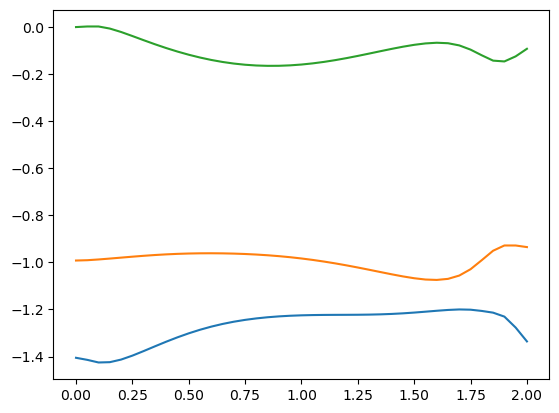

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000A68F84D0>

In [19]:
plot(thist,xtraj[4,:])
plot(thist,xtraj[5,:])
plot(thist,xtraj[6,:])

In [20]:
xtraj[:, Nt-1]

12-element Vector{Float64}:
  -2.4046745453106375
  17.152006313273656
 -15.919464995012202
  -1.2769620971163558
  -0.9282222084238441
  -0.1245019595978118
 -15.949516639450772
  10.437477098562479
  16.223290270086373
  -0.8392103801357964
  -0.4088160030567283
  -0.04906480322105161

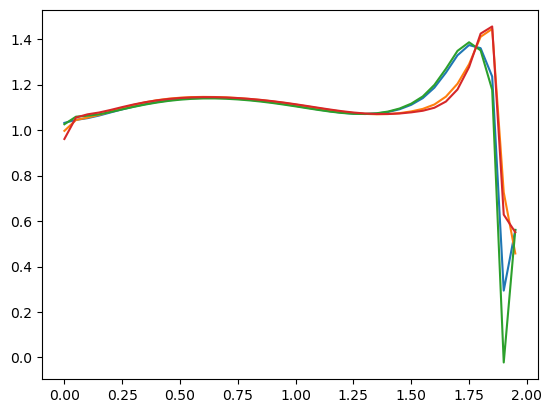

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000A718D4F0>

In [21]:
plot(thist[1:Nt-1],utraj[1,:])
plot(thist[1:Nt-1],utraj[2,:])
plot(thist[1:Nt-1],utraj[3,:])
plot(thist[1:Nt-1],utraj[4,:])

## Visualization

In [22]:
using TrajOptPlots
using MeshCat
using StaticArrays

vis = Visualizer()
render(vis)

┌ Warning: Error requiring `MathOptInterface` from `Optim`
│   exception =
│    LoadError: UndefVarError: VariablesContainer not defined
│    Stacktrace:
│      [1] getproperty(x::Module, f::Symbol)
│        @ Base .\Base.jl:35
│      [2] top-level scope
│        @ C:\Users\g.kirillov\.julia\packages\Optim\DV9Sq\ext\OptimMOIExt.jl:22
│      [3] include
│        @ .\Base.jl:419 [inlined]
│      [4] _include(mapexpr::Function, m::Module, path::String)
│        @ PackageExtensionCompat C:\Users\g.kirillov\.julia\packages\PackageExtensionCompat\BTCUg\src\PackageExtensionCompat.jl:12
│      [5] top-level scope
│        @ none:1
│      [6] eval
│        @ .\boot.jl:373 [inlined]
│      [7] eval
│        @ C:\Users\g.kirillov\.julia\packages\Optim\DV9Sq\src\Optim.jl:17 [inlined]
│      [8] (::Optim.var"#153#156")()
│        @ Optim C:\Users\g.kirillov\.julia\packages\Requires\1eCOK\src\require.jl:101
│      [9] macro expansion
│        @ timing.jl:299 [inlined]
│     [10] err(f::Any, listener

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8700))

In [23]:
TrajOptPlots.set_mesh!(vis, a)

false

In [24]:
function change_state_form(x)
    out = zeros(13)
    out[1:3] .= x[1:3]
    q = UnitQuaternion(RotZYX(x[6], x[5], x[4]))
    out[4] = q.w
    out[5] = q.x
    out[6] = q.y
    out[7] = q.z
    out[8:13] .= x[7:12]
    return out
end

change_state_form (generic function with 1 method)

In [25]:
X1 = [SVector{13}(change_state_form(x)) for x in eachcol(xtraj)];

visualize!(vis, a, thist[end], X1)

# Feasible angles visualization

In [26]:
# Number of divisions for the sphere
Count = 20

# Generate the sphere mesh
θ = range(0, stop=π, length=Count)
ϕ = range(0, stop=2π, length=Count)
X = [sin(t)*cos(p) for t in θ, p in ϕ]
Y = [sin(t)*sin(p) for t in θ, p in ϕ]
Z = [cos(t) for t in θ, _ in ϕ]

20×20 Matrix{Float64}:
  1.0         1.0         1.0        …   1.0         1.0         1.0
  0.986361    0.986361    0.986361       0.986361    0.986361    0.986361
  0.945817    0.945817    0.945817       0.945817    0.945817    0.945817
  0.879474    0.879474    0.879474       0.879474    0.879474    0.879474
  0.789141    0.789141    0.789141       0.789141    0.789141    0.789141
  0.677282    0.677282    0.677282   …   0.677282    0.677282    0.677282
  0.546948    0.546948    0.546948       0.546948    0.546948    0.546948
  0.401695    0.401695    0.401695       0.401695    0.401695    0.401695
  0.245485    0.245485    0.245485       0.245485    0.245485    0.245485
  0.0825793   0.0825793   0.0825793      0.0825793   0.0825793   0.0825793
 -0.0825793  -0.0825793  -0.0825793  …  -0.0825793  -0.0825793  -0.0825793
 -0.245485   -0.245485   -0.245485      -0.245485   -0.245485   -0.245485
 -0.401695   -0.401695   -0.401695      -0.401695   -0.401695   -0.401695
 -0.546948   -0.54

## iLQR iterations

In [27]:
e = [0.0, 0.0, 1.0]
function get_euler_angles(n)
        if norm(n) < 1e-8
            next!(bar)
            # print(n)
            return NaN
        end
        n = n / norm(n)
        pitch = cross(e, n)
        if norm(pitch) < 1e-8
            next!(bar)
            # print(n, pitch)
            return NaN
        end
        pitch = pitch / norm(pitch)
        b = cross(pitch, n)
        if norm(b) < 1e-8
            next!(bar)
            # print(n, pitch, b)
            return NaN
        end
        b = b / norm(b)

        T = RotZYX([n pitch b])
        # correct inital conditions
        return [T.theta3, T.theta2, T.theta1]
end

get_euler_angles (generic function with 1 method)

## Set up desired state

In [28]:
xgoal = [0.0; 0; 0; pi/6; 0; 0; 0; 0; 0; 0; 0; 0]

12-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.5235987755982988
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [29]:
# ошибку вычисляем с помощью матриц вращения, потом перевести в angleaxis. Вывести только угол ошибки
function calculate_error(last_pos)
    ang_error = 0.0
    pos_error = 0.0
    r_des = xgoal[1:3]
    euler_des = xgoal[4:6]
    x = last_pos
    r = x[1:3]
    euler = x[4:6]
    R_des = RotZYX(euler_des[3], euler_des[2], euler_des[1])
    R = RotZYX(euler[3], euler[2], euler[1])
    err_matrix = R * inv(R_des)
    ang_error = AngleAxis(err_matrix).theta
    pos_error = norm(r-r_des)
    return ang_error + pos_error
end

calculate_error (generic function with 1 method)

In [30]:
using ProgressMeter
bar = Progress(Count * Count, desc="Iteration: ")
#DDP Algorithm
#Initial Rollout
e = [0.0, 0.0, 1.0]
Hmap_iterations = zeros(Count,Count)
Hmap_time = zeros(Count,Count)
Hmap_error = zeros(Count,Count)
Hmap_cost = zeros(Count, Count)
for i in 1:Count
    for j in 1:Count
        t_start = time()
        iter = 0
        # Tramsform sphere coords to euler angles:
        n = [X[i,j], Y[i,j], Z[i,j]]

        euler_angs = get_euler_angles(n)

        if any(isnan, euler_angs)
            Hmap_iterations[i,j] = NaN
            Hmap_time[i,j] = NaN
            Hmap_error[i,j] = NaN
            Hmap_cost[i,j] = NaN
            continue
        end
        
        x0[4:6] .= euler_angs
        # correct initial trajectory
        xtraj = kron(ones(1,Nt), x0)
        utraj = zeros(Nu, Nt-1) .+ uhover
        for k = 1:(Nt-1)
            xtraj[:,k+1] .= dynamics_rk4(xtraj[:,k],utraj[:,k])
        end
        J = cost(xtraj,utraj)
        # iLQR start
        p = ones(Nx,Nt)
        P = zeros(Nx,Nx,Nt)
        d = ones(Nu,Nt-1)
        K = zeros(Nu,Nx,Nt-1)
        ΔJ = 1.0
        
        xn = zeros(Nx,Nt)
        un = zeros(Nu,Nt-1)
        
        gx = zeros(Nx)
        gu = zeros(Nu)
        Gxx = zeros(Nx,Nx)
        Guu = zeros(Nu)
        Gxu = zeros(Nx)
        Gux = zeros(Nx)
        
        Jp = 0
        stop = false
        while abs(Jp-J) >  5 * 1e-5
            if stop
                break
            end
            iter += 1    
            
            #Backward Pass
            ΔJ = backward_pass!(p,P,d,K)
            if isnan(ΔJ)
                stop = true
                break
            end
            #Forward rollout with line search
            xn[:,1] = xtraj[:,1]
            α = 1.0
            
            # display(K[:,:,1] * (xn[:,1]-xtraj[:,1]))
            # display(utraj[:,1] - α*d[:,1] - K[:,:,1] * (xn[:,1]-xtraj[:,1]))
            
            for k = 1:(Nt-1)
                un[:,k] .= utraj[:,k] - α*d[:,k] - K[:,:,k] * (xn[:,k]-xtraj[:,k])
                try
                    xn[:,k+1] .= dynamics_rk4(xn[:,k],un[:,k])
                catch err
                    stop = true 
                end
            end
            Jn = cost(xn,un)
            # display(Jn)
            while isnan(Jn) || Jn > (J - 1e-2*α*ΔJ)
                α = 0.5*α
                for k = 1:(Nt-1)
                    un[:,k] .= utraj[:,k] - α*d[:,k] - K[:,:,k] * (xn[:,k]-xtraj[:,k])
                    try
                        xn[:,k+1] .= dynamics_rk4(xn[:,k],un[:,k])
                    catch err
                        # print("Current x: $(xn[:,k])\n")
                        # print("Current u: $(un[:,k-1])\n")
                        # print("Previous x: $(xn[:,k-2])\n")
                        stop = true
                    end
                end
                Jn = cost(xn,un)
                # display(Jn)
            end
            
            Jp = J
            J = Jn
            xtraj .= xn
            utraj .= un

        end
        if stop
            Hmap_iterations[i,j] = NaN
            Hmap_time[i,j] = NaN
            Hmap_error[i,j] = NaN
            Hmap_cost[i,j] = NaN
        else
            Hmap_iterations[i,j] = iter
            Hmap_time[i,j] = time() - t_start
            Hmap_error[i,j] = calculate_error(xtraj[:, Nt])
            Hmap_cost[i,j] = J
        end
        next!(bar)
    end
end

Iteration: 100%|████████████████████████████████████████| Time: 0:51:08


## Saving obtained iteration heatmap

In [31]:
@save "euler/ua/FD/Hmap_euler_FD_iter.jld2" Hmap_iterations
@save "euler/ua/FD/Hmap_euler_FD_time.jld2" Hmap_time
@save "euler/ua/FD/Hmap_euler_FD_error.jld2" Hmap_error
@save "euler/ua/FD/Hmap_euler_FD_cost.jld2" Hmap_cost

## Graph Plotting

In [32]:
@load "euler/ua/FD/Hmap_euler_FD_iter.jld2" Hmap_iterations
@load "euler/ua/FD/Hmap_euler_FD_time.jld2" Hmap_time
@load "euler/ua/FD/Hmap_euler_FD_error.jld2" Hmap_error
@load "euler/ua/FD/Hmap_euler_FD_cost.jld2" Hmap_cost

1-element Vector{Symbol}:
 :Hmap_cost

In [33]:
# Start the figure
pygui(true)
Hmap_norm = Hmap_error ./ maximum(filter(!isnan, Hmap_error))
fig = PyPlot.figure()
ax = fig.add_subplot(111, projection="3d")
# Custom colormap
cmap = PyPlot.get_cmap("cividis", 256)
cmap.set_bad("red")     # NaNs or masked values
# newcolors = cmap(LinRange(0, 1, 256))
# Red for failing intial conditions
# red = [256/256; 0/256; 0/256; 1]
# newcolors[:1, :] .= red
# newcmp = PyPlot.matplotlib.colors.ListedColormap(newcolors)
colors = cmap.(Hmap_norm)

psm = ax.plot_surface(X, Y, Z,
    facecolors=colors,
    linewidth=0.5, alpha=0.5,
    shade=false)

ax.set_box_aspect([1,1,1])  # Equal aspect ratio
cbar = fig.colorbar(psm, ax=ax)
cbar.set_ticks([0, 1])  # Show ticks at the normalized range
cbar.set_ticklabels([0, maximum(filter(!isnan, Hmap_error))])  # Map ticks back to the original data range
PyPlot.tight_layout()
PyPlot.show()

## Check iteration values and invalid angle values

In [34]:
Hmap

LoadError: UndefVarError: Hmap not defined

In [35]:
# Check that there is no values close to 0 (so, they will be red)
thold = 100
findall(x -> x < thold && x != 0, Hmap)

LoadError: UndefVarError: Hmap not defined

In [36]:
zero_inds = findall(==(NaN), Hmap)

for idx in zero_inds
    i, j = Tuple(idx)
    n = [X[i,j], Y[i,j], Z[i,j]]
    
    angls = get_euler_angles(n)
    if !any(isnan, angls)
        println(angls)
    end
end

LoadError: UndefVarError: Hmap not defined